By [Kevin Michalewicz](https://kevinmichalewicz.com) and [Martin Millon](https://martin-millon.gitlab.io/) on August 2022

This notebook details how to deconvolve a single image of the DESJ0602-4335 lensed quasar using the automated deconvolution routine of STARRED. 

## Principle and formulation

Let $d(\mathbf{x})$ be an observation corrupted by additive noise $n(\mathbf{x})$. The idea is to use a narrow function $s(\mathbf{x})$ to perform the deconvolution operation and obtain $f(\mathbf{x})$. The following can be written

$$d(\mathbf{x})=s(\mathbf{x})*f(\mathbf{x})+n(\mathbf{x})$$

$f$ can be expressed as a function of free parameters $a_k$ and $\mathbf{c}_k$

$$f(\mathbf{x})=h(\mathbf{x})+\sum_{k=1}^{M}a_kr(\mathbf{x}-\mathbf{c}_k)$$

* $r(\mathbf{x})$ is a 2-pixel FWHM Gaussian
* $h(\mathbf{x})$ is a grid of pixels
* $M$ is the number of point sources, located at $\mathbf{c}_k = \begin{bmatrix}c_{x_k} & c_{y_k}\end{bmatrix}^\text{T}$ for $k=1,\dots,M$
* $a_k$ are the Gaussian amplitudes associated to each of them


The following objective function needs to be minimized

$$\mathcal{S}=\sum_{i=1}^{N}\frac{1}{\sigma_i^2}\left[\left(s_{i} * h_i+s_{i} * \sum_{k=1}^{M}a_kr(\mathbf{x}_i-\mathbf{c}_k)\right)^\downarrow-d_i\right]^2+\lambda_{\text{scales}}\Big\lVert\phi_{\text{scales}}\big(h(\mathbf{x})\big)\Big\rVert_1+\lambda_{\text{hf}}\Big\lVert\phi_{\text{hf}}\big(h(\mathbf{x})\big)\Big\rVert_1$$

* $N_e$ is the number of epochs
* $\phi(\cdot)$ is the Starlet transform operator
* $\downarrow$ performs the downsampling operation
* $\sigma_i$ is the noise level at each pixel of the data
* $\lambda_{\text{hf}}$ is the Lagrange parameter that weights the presence of the highest frequencies of the grid of pixels $h(\mathbf{x})$
* $\lambda_{\text{scales}}$ is the Lagrange parameter that weights all other scales (except the coarsest one)

*Fact:* given a $\frac{\sqrt{N}}{D}\times\frac{\sqrt{N}}{D}$ input with $M$ point sources, $N+3M$ parameters are needed to construct $f$ (a downsampling factor $D$ is assumed here). 

### Joint deconvolution of multiple epochs
If we have multiple epochs at once, we also sum over the epochs when calculating the cost function. The following applies:
- $h$ is the same for every epoch,
- the amplitudes of the point sources can vary from one epoch to the next, but not their relative positions,
- a global shift is allowed at each epoch,
- the PSF varies from one epoch to the next.

**In this example we will perform a joint deconvolution of two epochs, but this notebook can be used for a single epoch as well.**

In [1]:
import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook 
# uncomment the above to use the interactive plots.
import os
from copy import deepcopy
from matplotlib import colors

from starred.deconvolution.deconvolution import Deconv, setup_model, load_Deconv_model
from starred.deconvolution.loss import Loss, Prior
from starred.deconvolution.parameters import ParametersDeconv
from starred.utils.noise_utils import propagate_noise
from starred.optim.optimization import Optimizer
from starred.plots.plot_function import plot_deconvolution, view_deconv_model, plot_loss
from starred.procedures.deconvolution_routines import multi_steps_deconvolution

# Data setup

In [2]:
# Parameters
t_exp = 1 # in seconds, as the image is in ADU
gain = 2. # WFI camera inverse gain in e-/ADU
subsampling_factor = 2 # the upsampling we used to represent the PSF
# since the noise is normalized,
# you will typically want your lambda_scale (regularization strength) relatively close to 1.
lambda_scales = 3.
# lambda_hf should be set to a high number in this example. We aggressively denoise the first starlet scales since we deconvolve only two 5 min exposures
#if you have a higher SNR in your data, you could set lambda_scales = lambda_hf = 3. 
lambda_hf = 500.
data_path = 'data/2_observations'
psf_path = 'data/2_psfs'
convolution_method = 'fft'

In [3]:
# Retrieving data
### if you want a single epoch, just prepare a data directory with a single file
### instead of 2 like we have here.
file_paths = sorted(glob.glob(os.path.join(data_path, '*.npy')))
data = np.array([np.load(f) for f in file_paths]) * t_exp * gain

im_size = np.shape(data)[1]
epochs = np.shape(data)[0]
print(data.shape)

(2, 64, 64)


In [4]:
# Retrieving the PSF (must have one per epoch)
file_paths = sorted(glob.glob(os.path.join(psf_path, '*.npy')))
s = np.array([np.load(f) for f in file_paths])

im_size_up = s.shape[1]
print(s.shape)

(2, 128, 128)


Let's see what the data is like:

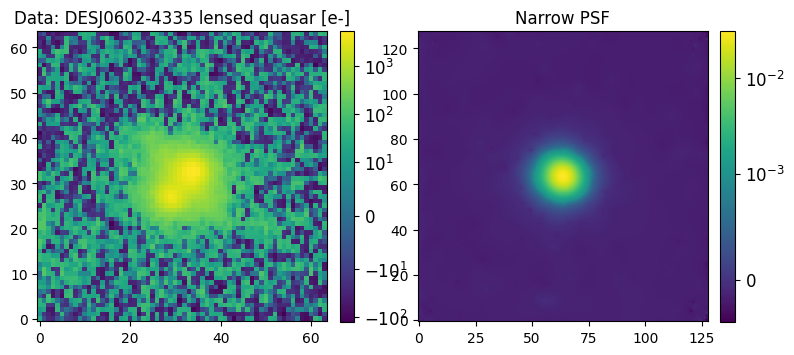

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(9,6))
fraction = 0.046
pad = 0.04

plt.rc('font', size=12)           
axs[0].set_title('Data: DESJ0602-4335 lensed quasar [e-]', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[1].set_title('Narrow PSF', fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=10)

fig.colorbar(axs[0].imshow(data[0,...], norm=colors.SymLogNorm(linthresh=10), origin='lower'), ax=axs[0], fraction=fraction, pad=pad)
fig.colorbar(axs[1].imshow(s[0,...], norm=colors.SymLogNorm(linthresh=1e-3), origin='lower'), ax=axs[1], fraction=fraction, pad=pad)
plt.show()

In [6]:
# Noise map
sigma_2 = np.zeros((epochs, im_size, im_size))
sigma_sky_2 = np.array([np.std(data[i,int(0.9*im_size):,int(0.9*im_size):]) for i in range(epochs)]) ** 2
for i in range(epochs):
    sigma_2[i,:,:] = sigma_sky_2[i] + data[i,:,:].clip(min=0)

#normalise (to facilitate the job of the optimiser): 
norm = data.max() / 100
data = data / norm 
sigma_2 = sigma_2 / norm**2


Now we are going to create our deconvolution model. We will need the positions of our point sources, which we can read from the figure above. We will also need an estimation of the amplitude of each point source. These are best estimated iteratively by running this cell repeatidly and looking at the residuals.

# Starred model setup

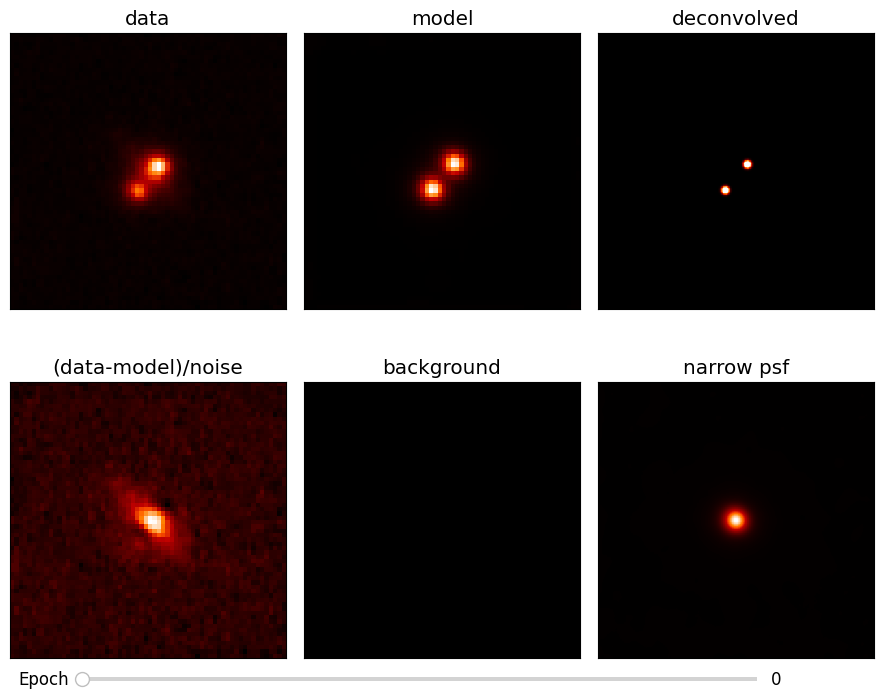

In [7]:
# positions of point sources, relative to center of image data.
initial_c_x = np.array([-2.2, 2.9])
initial_c_y = np.array([-4.2, 1.8])
# we give the inital amplitude for one epoch. The setup function
# replicates them for all epochs. You can fine tune this later
# if you feel like your amplitudes are widely different on an
# epoch-per-epoch basis.
pts_amp = [500,500] 
initial_a = [pts_amp[j]  for i in range(epochs) for j in range(len(pts_amp))]

model, kwargs_init, kwargs_up, kwargs_down, kwargs_fixed = setup_model(data, 
                                                                       sigma_2, 
                                                                       s, 
                                                                       initial_c_x,
                                                                       initial_c_y,
                                                                       subsampling_factor,
                                                                       initial_a,
                                                                       )

parameters = ParametersDeconv(kwargs_init, 
                              kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)


# we can use this to inspect our inital conditions, are they reasonable?
view_deconv_model(model, kwargs_init, data, sigma_2)
# yep they are reasonable, our point sources fall more or less
# in the correct positions, and their amplitudes more or less
# cancel those of the data.

We provided a clean guess for the position and amplitudes of the point sources. As you can see, the two PSFs were well subtracted, leaving only the footprint of the galaxy. 

We will now try to capture this galaxy with the starlet-regularized background channel of our deconvolution.

# Optimization
`STARRED` provides users with several optimization algorithms from `jaxopt` as well as `adabelief` from `optax`.

`LBFGS` is a gradient-based optimization algorithm that approximates the inverse Hessian matrix using a limited memory approach. It typically requires fewer iterations to converge than `adabelief`. The `l-bfgs-b` version can handle boundaries, the `kwargs_up` and `kwargs_down` dictionaries defined in this notebook.

From our tests as of the writing of this notebook, `l-bfgs-b` converges within fewer iterations, and is faster on CPU due to needing fewer calls to the loss function. On the other hand, `adabelief` is extremely swift on GPU, faster than `l-bfgs-b` even when thousands of iterations are needed to reach a minimum.

We recommend using  `adabelief` when optimising the background and `l-bfgs-b` when optimising only the 'analytical parameters', i.e. when the pixel grid is not optimised. `l-bfgs-b` modify the relative weight between the data fidelity term and the regularisation term in hte loss function by adding an extra term to penalise out-of-bounds parameters. Therefore, we recommend not using it when the regularisation is activated (`lambda_scales != 0 ` or `lambda_hf!= 0`).

# Fitting sequence
To avoid getting stuck in local minima, we recommend to fix the astrometry for the first iteration and then release all free parameters.
You can define a custom fitting sequence by fixing the photometry, the astrometry, the background or the Sérsic profiles, if you decided to model your background with Sérsic profiles (see Notebook 3).



In [8]:
#Selecting the fixed components at each step, the rest is free. Format [['pts-source-astrometry','pts-source-photometry','background'],['pts-source-astrometry','pts-source-photometry'], ...]
fitting_sequence = [
                    ['pts-source-astrometry'], #step 1 : raise background, keeping astrometry fixed
                    # ['background'], #step 2 : keep background fix, adjust astrometry
                    [], #step 3 : Adjust everything at once
        ]
    
#We use l-bfgs-b when the background is fixed (small number of free parameters) and adabelief otherwise
optim_list = ['adabelief','adabelief']

#We define the parameters of the optimiser. The important one are 'init_learning_rate' and 'max_iterations'
kwargs_optax1 = {
        'max_iterations': 300,
        'init_learning_rate': 1e-1, 
        'schedule_learning_rate': True,
    }

kwargs_optax2 = {
        'max_iterations': 500,
        'init_learning_rate': 1e-2, 
        'schedule_learning_rate': True,
    }
#if you are using l-bfgs-b, you can use the following parameters: 
#kwargs_lbfgs = {'maxiter':1000}

#list of configuration for the optimsers 
# kwargs_optim_list = [kwargs_optax1, kwargs_lbfgs, kwargs_optax2] 
kwargs_optim_list = [kwargs_optax1, kwargs_optax2] 

#we apply our astrometric prior nonly when the point sources are free (i.e. not for the second step). Here we don't use any prior on the point sources position.
#prior = Prior(prior_analytic=[['c_x',initial_c_x,1.], ['c_y',initial_c_y, 1.]], prior_background=None) #gaussian prior with sigma=1pixel for the position of the point sources.
#prior_list=[None,prior,None]
prior_list=[None,None]


## Run the fitting sequence

Step 1, fixing : ['pts-source-astrometry']


optax.adabelief: 100%|██████████| 300/300 [00:33<00:00,  8.98it/s]


Step 1/2 took 34 seconds
Kwargs partial at step 1/2 {'kwargs_analytic': {'a': Array([4.6114326, 6.9426527, 4.2420917, 6.2471514], dtype=float32), 'c_x': Array([-2.2,  2.9], dtype=float32), 'c_y': Array([-4.2,  1.8], dtype=float32), 'dx': Array([-0.35594448, -0.37791258], dtype=float32), 'dy': Array([-0.51362556, -0.46397826], dtype=float32), 'alpha': Array([0., 0.], dtype=float32)}, 'kwargs_background': {'mean': Array([0., 0.], dtype=float32), 'h': Array([0.00634494, 0.01673352, 0.04245321, ..., 0.12496505, 0.11105753,
       0.04637615], dtype=float32)}, 'kwargs_sersic': {'amp': Array([], dtype=float32), 'R_sersic': Array([], dtype=float32), 'n_sersic': Array([], dtype=float32), 'center_x': Array([], dtype=float32), 'center_y': Array([], dtype=float32), 'e1': Array([], dtype=float32), 'e2': Array([], dtype=float32)}}
Loss :  8785.483
Overall Reduced Chi2 :  1.6170762
Step 2, fixing : []


optax.adabelief: 100%|██████████| 500/500 [00:44<00:00, 11.28it/s]


Step 2/2 took 44 seconds
Kwargs partial at step 2/2 {'kwargs_analytic': {'a': Array([5.243323, 7.093215, 4.857344, 6.3872  ], dtype=float32), 'c_x': Array([-1.8673162,  2.8911438], dtype=float32), 'c_y': Array([-4.0273943,  1.6778226], dtype=float32), 'dx': Array([-0.47571483, -0.4992702 ], dtype=float32), 'dy': Array([-0.52161515, -0.46926954], dtype=float32), 'alpha': Array([0., 0.], dtype=float32)}, 'kwargs_background': {'mean': Array([0., 0.], dtype=float32), 'h': Array([0.00690869, 0.00956778, 0.01452737, ..., 0.13152215, 0.10541661,
       0.06073917], dtype=float32)}, 'kwargs_sersic': {'amp': Array([], dtype=float32), 'R_sersic': Array([], dtype=float32), 'n_sersic': Array([], dtype=float32), 'center_x': Array([], dtype=float32), 'center_y': Array([], dtype=float32), 'e1': Array([], dtype=float32), 'e2': Array([], dtype=float32)}}
Loss :  7409.6147
Overall Reduced Chi2 :  1.58766


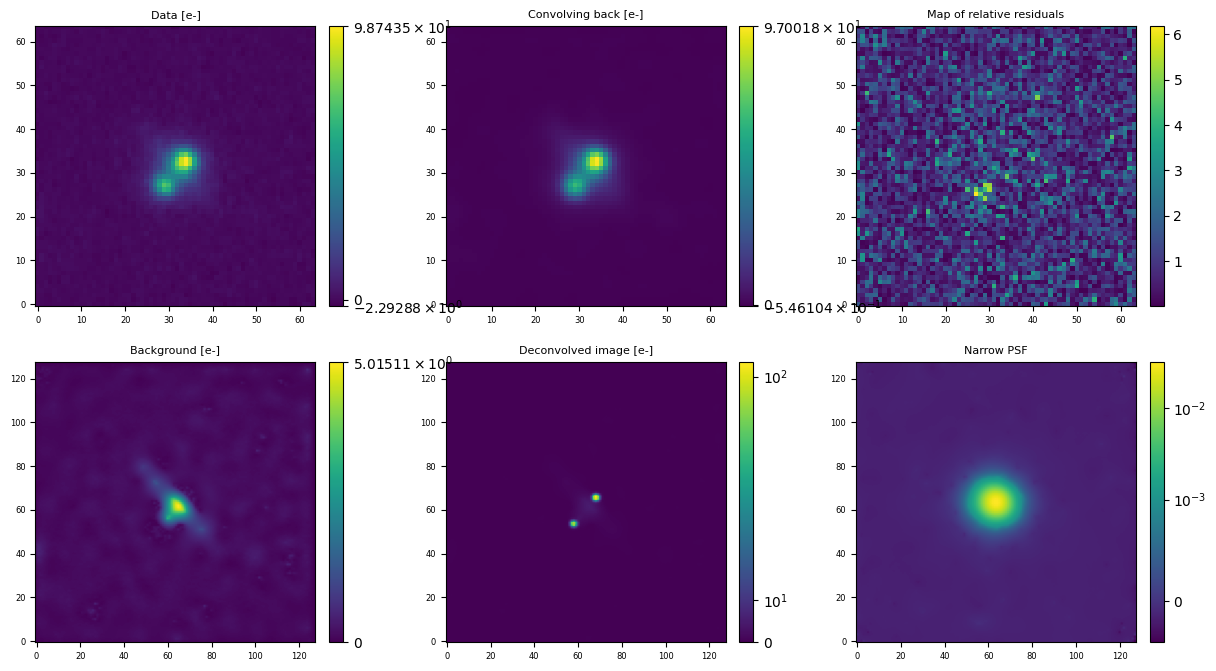

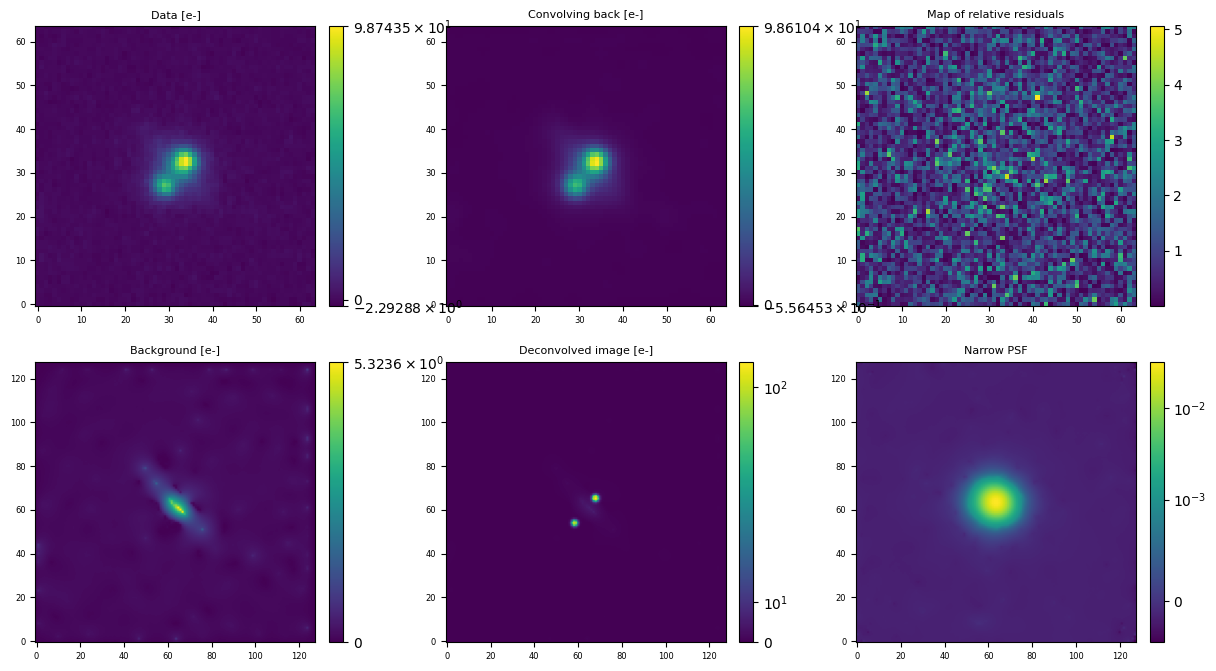

In [9]:
model, parameters, loss, kwargs_partial_list, fig_list, LogL_list, loss_history_list = multi_steps_deconvolution(data, model, parameters, sigma_2, s, subsampling_factor,
                                                                                    fitting_sequence = fitting_sequence,
                                                                                    optim_list = optim_list, kwargs_optim_list = kwargs_optim_list,
                                                                                    lambda_scales = lambda_scales, lambda_hf =lambda_hf, 
                                                                                    prior_list = prior_list)

## Verify the convergence

Step 1, optimiser adabelief
Step 2, optimiser adabelief


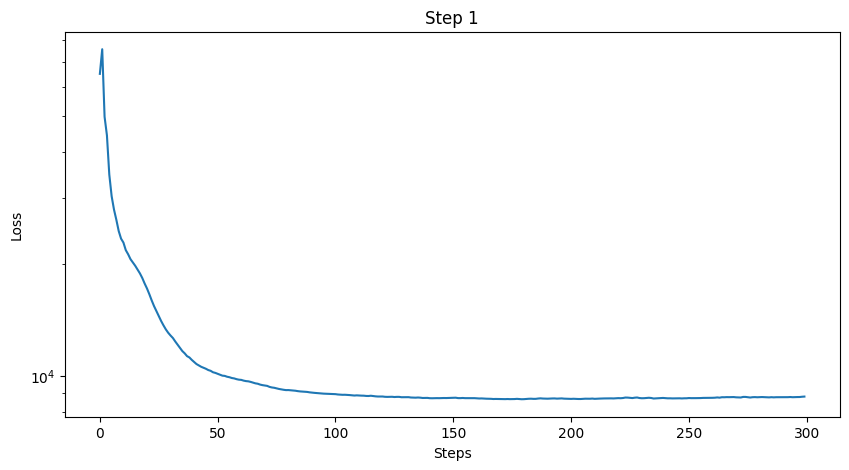

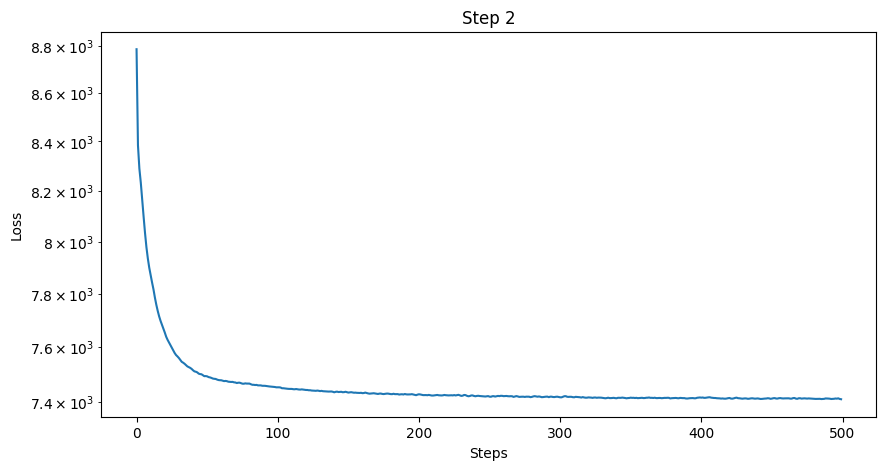

In [10]:
for i in range(len(loss_history_list)):
    print('Step %i, optimiser %s'%(i+1, optim_list[i]))
    plot_loss(loss_history=loss_history_list[i], title = 'Step %i'%(i+1))

# Results

{'kwargs_analytic': {'a': Array([5.243323, 7.093215, 4.857344, 6.3872  ], dtype=float32), 'c_x': Array([-1.8673162,  2.8911438], dtype=float32), 'c_y': Array([-4.0273943,  1.6778226], dtype=float32), 'dx': Array([-0.47571483, -0.4992702 ], dtype=float32), 'dy': Array([-0.52161515, -0.46926954], dtype=float32), 'alpha': Array([0., 0.], dtype=float32)}, 'kwargs_background': {'mean': Array([0., 0.], dtype=float32), 'h': Array([0.00690869, 0.00956778, 0.01452737, ..., 0.13152215, 0.10541661,
       0.06073917], dtype=float32)}, 'kwargs_sersic': {'amp': Array([], dtype=float32), 'R_sersic': Array([], dtype=float32), 'n_sersic': Array([], dtype=float32), 'center_x': Array([], dtype=float32), 'center_y': Array([], dtype=float32), 'e1': Array([], dtype=float32), 'e2': Array([], dtype=float32)}}
Overall Reduced Chi2 :  1.58766


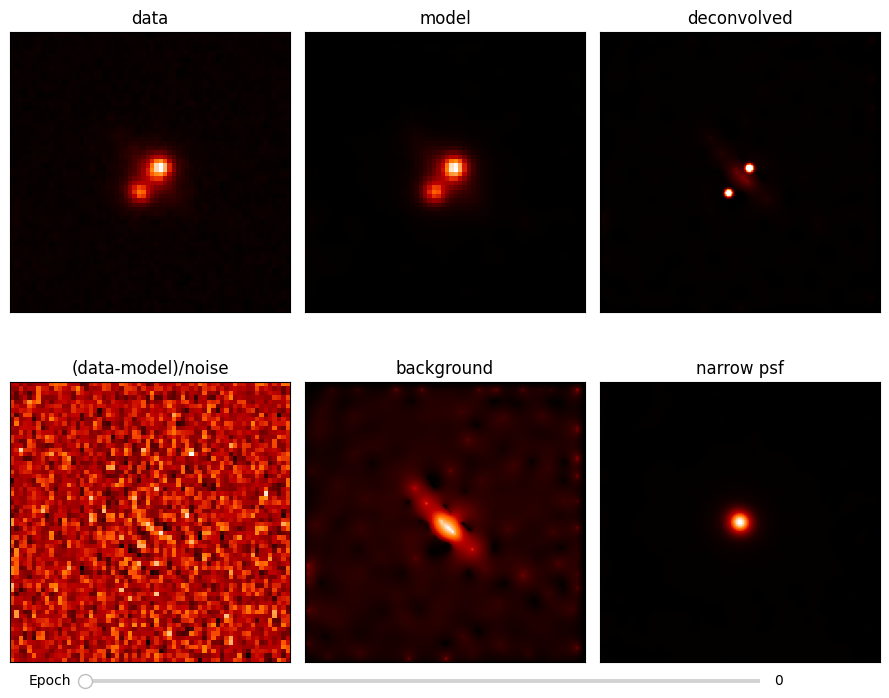

In [16]:
# Printing final results
kwargs_final = deepcopy(parameters.best_fit_values(as_kwargs=True))
print(kwargs_final)
print('Overall Reduced Chi2 : ', loss.reduced_chi2(kwargs_final))
# we can use our crude inspection plot function:
view_deconv_model(model, kwargs_final, data, sigma_2)

## Another plot function
You can adjust the color cut in the `cut_dict` variable

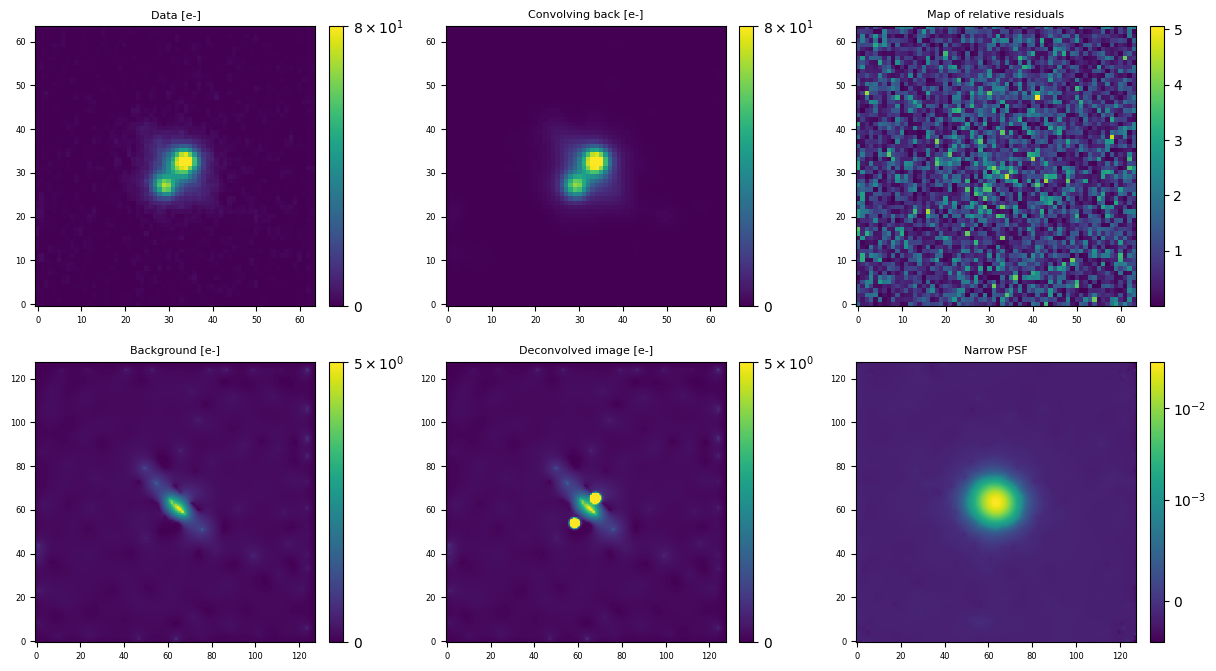

In [17]:
# or we can make a nicer looking plot,  
# with another STARRED plot function offering
# more control over the cuts.

# Retrieving different elements of the deconvolved image
epoch = 0
output = model.model(kwargs_final)[epoch] 
deconv, h = model.getDeconvolved(kwargs_final, epoch)


#cut of the panels, given from left to right and from top to bottom
cut_dict = {
            'linthresh':[200,200,None,100,100,1e-3],
            'vmin':[0,0, None, 0, 0, None],
            'vmax':[80, 80, None,5,5, None],
        }
fig2 = plot_deconvolution(model, data, sigma_2, s, kwargs_final, epoch = epoch, units='e-', cut_dict=cut_dict)

## Saving the model

In [13]:
# We'll save our model in our notebook directory.
# Uncomment the following line to save the obtained deconvolved image

# output_folder = Path('./output/DESJ0602/')
# output_folder.mkdir(parents=1, exist_ok=1)
# model.export(output_folder, kwargs_final, data, sigma_2, epoch=None, format='fits') #save the product in fits files
# model.dump(os.path.join(output_folder, 'model.hdf5'), kwargs_final, data, sigma_2, save_output_level=4, format='hdf5') #save the model in hdf5 format

In [14]:
#reload previous model 
# import h5py 

# model_rec, kwargs_rec, data_rec, sigma_2_rec = load_Deconv_model(os.path.join(output_folder, 'model.hdf5'), format='hdf5')
# with h5py.File(os.path.join(output_folder, 'model.hdf5'), 'r') as f: 
#      print(f.keys())